In [20]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from pathlib import Path


In [21]:
BASE_DIR = Path("../data/processed/classification_split")

TRAIN_DIR = BASE_DIR / "train"
VAL_DIR = BASE_DIR / "val"
TEST_DIR = BASE_DIR / "test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print("Entrenando con rutas:")
print("Train:", TRAIN_DIR)
print("Val:", VAL_DIR)
print("Test:", TEST_DIR)


Entrenando con rutas:
Train: ..\data\processed\classification_split\train
Val: ..\data\processed\classification_split\val
Test: ..\data\processed\classification_split\test


In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.10,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 1965 images belonging to 2 classes.
Found 421 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [23]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

# Verificar versión de TensorFlow
print(f"TensorFlow version: {tf.__version__}")

# Crear el modelo base
try:
    base_model = MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    print("✅ MobileNetV2 creado exitosamente")
except Exception as e:
    print(f"❌ Error al crear MobileNetV2: {e}")
    print("Intentando con pesos aleatorios...")
    base_model = MobileNetV2(
        weights=None,
        include_top=False,
        input_shape=(224, 224, 3)
    )

# Congelar el modelo base
base_model.trainable = False

# Ver resumen
print("\nResumen del modelo base:")
print(f"Número de capas: {len(base_model.layers)}")
print(f"Número de parámetros totales: {base_model.count_params():,}")

TensorFlow version: 2.20.0
✅ MobileNetV2 creado exitosamente

Resumen del modelo base:
Número de capas: 154
Número de parámetros totales: 2,257,984


In [24]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Construcción del modelo final
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0008),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
#Callbacks (early stopping + guardar mejor modelo)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("models/classification/modelo_clasificador.h5",
                    save_best_only=True,
                    monitor="val_loss")
]


In [26]:
#Entrenamiento
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7251 - loss: 0.5530

62/62 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8438 - loss: 0.3493 - val_accuracy: 0.9810 - val_loss: 0.1055
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9727 - loss: 0.1097

62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9746 - loss: 0.1010 - val_accuracy: 0.9905 - val_loss: 0.0596
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9844 - loss: 0.0709

62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9852 - loss: 0.0613 - val_accuracy: 0.9929 - val_loss: 0.0493
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9951 - loss: 0.0403

62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9934 - loss: 0.0407 - val_accuracy: 0.9929 - val_loss: 0.0455
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9904 - loss: 0.0499

62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9903 - loss: 0.0438 - val_accuracy: 0.9905 - val_loss: 0.0453
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9945 - loss: 0.0309

62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9934 - loss: 0.0319 - val_accuracy: 0.9929 - val_loss: 0.0410
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9948 - loss: 0.0264

62/62 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9939 - loss: 0.0293 - val_accuracy: 0.9929 - val_loss: 0.0375
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9914 - loss: 0.0332

62/62 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9919 - loss: 0.0295 - val_accuracy: 0.9929 - val_loss: 0.0358
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9949 - loss: 0.0233 - val_accuracy: 0.9905 - val_loss: 0.0363
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9942 - loss: 0.0186

62/62 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9939 - loss: 0.0202 - val_accuracy: 0.9952 - val_loss: 0.0259
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9964 - loss: 0.0209 - val_accuracy: 0.9929 - val_loss: 0.0322
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9944 - loss: 0.0212 - val_accuracy: 0.9929 - val_loss: 0.0263
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9924 - loss: 0.0226 - val_accuracy: 0.9881 - val_loss: 0.0351
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9960 - loss: 0.0177

62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9964 - loss: 0.0168 - val_accuracy: 0.9952 - val_loss: 0.0239
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9970 - loss: 0.0140

62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9964 - loss: 0.0148 - val_accuracy: 0.9952 - val_loss: 0.0204
Epoch 16/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9969 - loss: 0.0140 - val_accuracy: 0.9929 - val_loss: 0.0213
Epoch 17/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9944 - loss: 0.0163 - val_accuracy: 0.9929 - val_loss: 0.0272
Epoch 18/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9980 - loss: 0.0115 - val_accuracy: 0.9929 - val_loss: 0.0297
Epoch 19/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.9969 - loss: 0.0140 - val_accuracy: 0.9952 - val_loss: 0.0213
Epoch 20/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9990 - loss: 0.0102 - val_accuracy: 0.9929 - val_loss: 0.0308


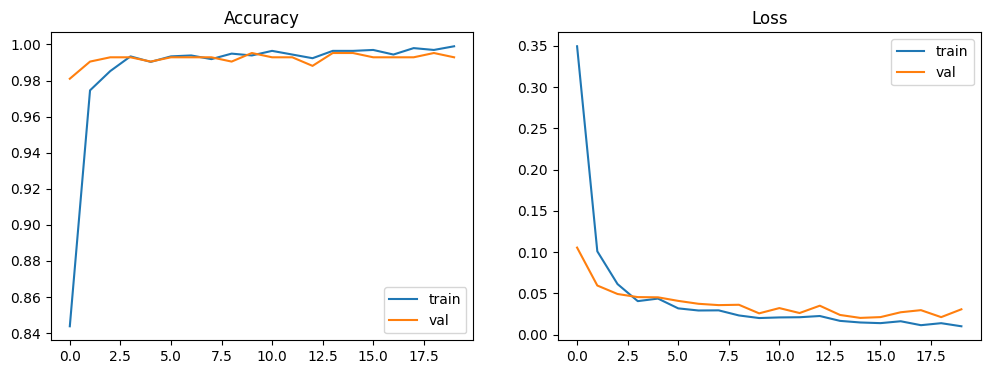

In [27]:
#Gráficos de accuracy y loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.title("Loss")

plt.show()


In [28]:
#Evaluación en test
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)


14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9976 - loss: 0.0101
Test Accuracy: 0.9976303577423096


In [29]:
#Guardar modelo TFLite (para usar offline)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("models/classification/modelo_clasificador.tflite", "wb") as f:
    f.write(tflite_model)

print("Modelo TFLite exportado")


INFO:tensorflow:Assets written to: C:\Users\Leo\AppData\Local\Temp\tmpkwy0un3y\assets


INFO:tensorflow:Assets written to: C:\Users\Leo\AppData\Local\Temp\tmpkwy0un3y\assets


Saved artifact at 'C:\Users\Leo\AppData\Local\Temp\tmpkwy0un3y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_783')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1677783898960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677783901264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677783901072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677783900304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677783901840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677783899344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677783901456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677783901648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677783900688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1677783902800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  167